<a href="https://colab.research.google.com/github/awaiskhan005/DEEP-LEARNING-AND-FORECASTING/blob/main/CRNT_STOCK_Hybird_(XG%2BLSTM)_Prediction_for_NEXT_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training XGBoost Model...
early_stopping_rounds not supported in your XGBoost version; fitting without it.

XGBoost Performance:
MAE: 0.0774
MSE: 0.0186
R²: 0.9742


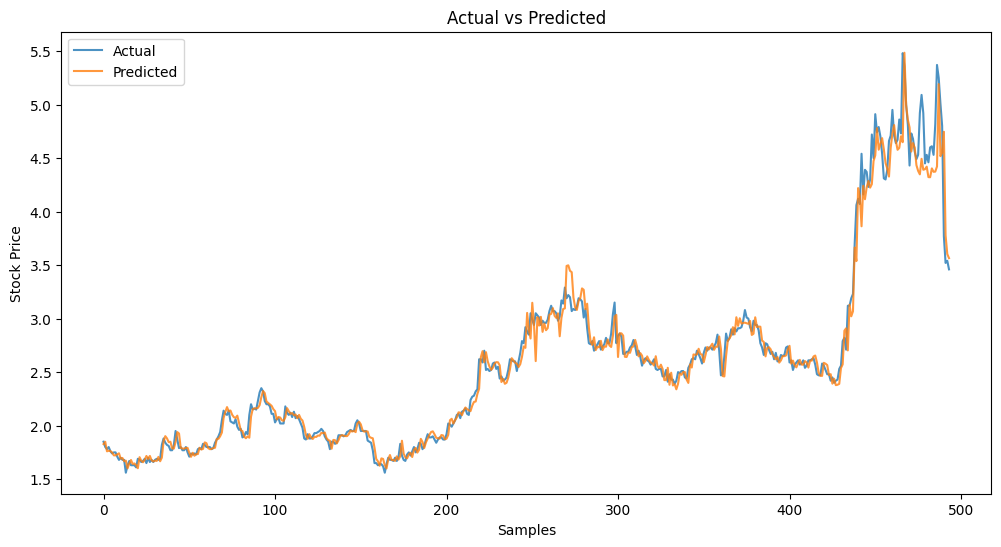


Training LSTM Model...
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 6.2698 - val_loss: 2.3945
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5387 - val_loss: 0.8827
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6074 - val_loss: 0.3428
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2423 - val_loss: 0.1334
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1171 - val_loss: 0.0947
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0807 - val_loss: 0.0635
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0647 - val_loss: 0.0572
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0516 - val_loss: 0.0469
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0451 - val_loss: 0.0399
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0404 - val_loss: 0.0393
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0391 - val_loss: 0.0331
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0402 - val_loss: 0.03

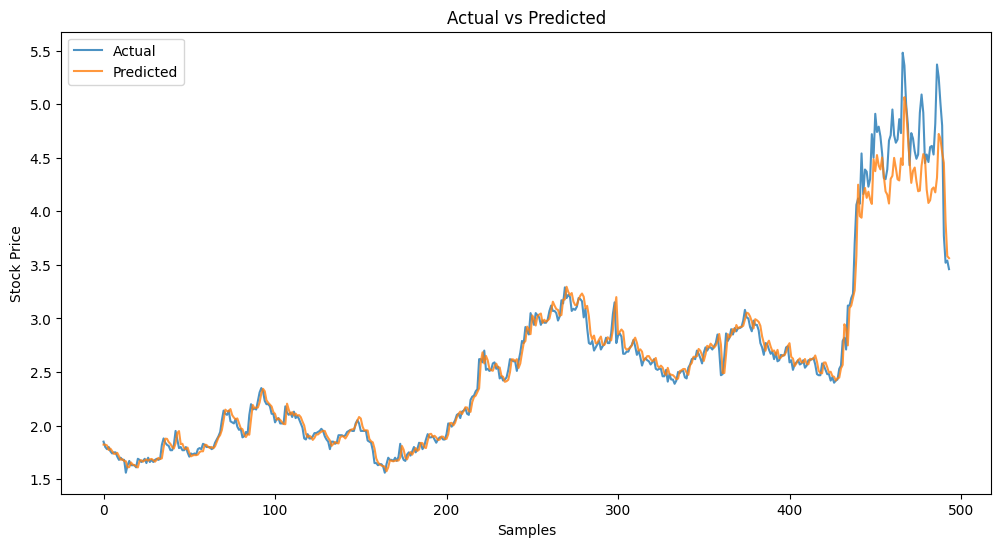

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Next Day Price Predictions:
XGBoost Prediction: 3.5647
LSTM Prediction:    3.5627
Ensemble Prediction (Average): 3.5637


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# -----------------------------
# Data Download and Feature Engineering
# -----------------------------
def download_data(ticker="CRNT", period="10y", interval="1d"):
    """Download historical stock data using yfinance."""
    stock = yf.Ticker(ticker)
    data = stock.history(period=period, interval=interval)
    return data

def add_technical_indicators(data):
    """Add technical indicators to the dataframe."""
    # Keep only needed columns and make an explicit copy to avoid SettingWithCopyWarning
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

    # Simple Moving Averages
    data.loc[:, 'SMA_20'] = data['Close'].rolling(window=20).mean()
    data.loc[:, 'SMA_50'] = data['Close'].rolling(window=50).mean()

    # Exponential Moving Averages
    data.loc[:, 'EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    data.loc[:, 'EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

    # Relative Strength Index (RSI)
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data.loc[:, 'RSI'] = 100 - (100 / (1 + rs))

    # Moving Average Convergence Divergence (MACD) and Signal Line
    ema12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema26 = data['Close'].ewm(span=26, adjust=False).mean()
    data.loc[:, 'MACD'] = ema12 - ema26
    data.loc[:, 'Signal_Line'] = data['MACD'].ewm(span=9, adjust=False).mean()

    # Bollinger Bands
    data.loc[:, 'Middle_Band'] = data['Close'].rolling(window=20).mean()
    rolling_std = data['Close'].rolling(window=20).std()
    data.loc[:, 'Upper_Band'] = data['Middle_Band'] + (2 * rolling_std)
    data.loc[:, 'Lower_Band'] = data['Middle_Band'] - (2 * rolling_std)

    return data

def add_lag_features(data, lags=[1, 2, 3]):
    """Add lagged closing price features to the dataframe."""
    for lag in lags:
        data.loc[:, f'Close_Lag_{lag}'] = data['Close'].shift(lag)
    return data

def add_target(data):
    """Set the target as the next day closing price."""
    data.loc[:, 'Target'] = data['Close'].shift(-1)
    return data

def preprocess_data(data):
    """Drop NA values and split data into features and target."""
    data.dropna(inplace=True)
    X = data.drop(['Target'], axis=1)
    y = data['Target']
    return X, y

# -----------------------------
# Model Training Functions
# -----------------------------
def train_xgboost(X_train, y_train, X_val, y_val):
    """Train an XGBoost regressor."""
    model = XGBRegressor(n_estimators=1000,
                         learning_rate=0.01,
                         max_depth=5,
                         verbosity=0)
    # Try using early_stopping_rounds; if not supported, fall back to basic fitting.
    try:
        model.fit(X_train, y_train,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=50,
                  verbose=False)
    except TypeError:
        print("early_stopping_rounds not supported in your XGBoost version; fitting without it.")
        model.fit(X_train, y_train)
    return model

def train_lstm(X_train, y_train, X_val, y_val, epochs=50, batch_size=32):
    """Build and train an LSTM model."""
    model = Sequential()
    # Input shape: (timesteps, features); we use timesteps=1.
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        validation_data=(X_val, y_val))
    return model, history

def evaluate_model(model, X_test, y_test, model_type='sklearn'):
    """Evaluate the model and plot predictions vs actual values."""
    if model_type == 'lstm':
        y_pred = model.predict(X_test).flatten()
    else:
        y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2  = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")

    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values, label='Actual', alpha=0.8)
    plt.plot(y_pred, label='Predicted', alpha=0.8)
    plt.title('Actual vs Predicted')
    plt.xlabel('Samples')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

# -----------------------------
# Main Pipeline
# -----------------------------
def main():
    # 1. Download CRNT stock data
    data = download_data("CRNT", period="10y", interval="1d")

    # 2. Create technical indicators and lag features
    data = add_technical_indicators(data)
    data = add_lag_features(data, lags=[1, 2, 3])
    data = add_target(data)

    # 3. Drop any rows with missing values and split features/target
    X, y = preprocess_data(data)

    # 4. Split into training and testing sets (80%-20% split; maintaining time order)
    split_index = int(0.8 * len(X))
    X_train = X.iloc[:split_index].copy()  # explicit copy to avoid warnings
    X_test  = X.iloc[split_index:].copy()
    y_train = y.iloc[:split_index].copy()
    y_test  = y.iloc[split_index:].copy()

    # 5. Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # -----------------------------
    # XGBoost Model
    # -----------------------------
    print("Training XGBoost Model...")
    model_xgb = train_xgboost(X_train_scaled, y_train, X_test_scaled, y_test)
    print("\nXGBoost Performance:")
    evaluate_model(model_xgb, X_test_scaled, y_test, model_type='sklearn')

    # -----------------------------
    # LSTM Model
    # -----------------------------
    # Reshape the data for LSTM: [samples, timesteps, features]
    # Here, we use timesteps=1 (each sample is a single timestep)
    X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
    X_test_lstm  = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

    print("\nTraining LSTM Model...")
    model_lstm, history = train_lstm(X_train_lstm, y_train, X_test_lstm, y_test, epochs=50, batch_size=32)
    print("\nLSTM Performance:")
    evaluate_model(model_lstm, X_test_lstm, y_test, model_type='lstm')

    # -----------------------------
    # Next Day Price Prediction
    # -----------------------------
    # Get the latest available data point (last row before the target shift)
    latest_data = data.iloc[-1].drop('Target').values.reshape(1, -1)
    latest_data_scaled = scaler.transform(latest_data)

    # Prediction using XGBoost
    next_day_price_xgb = model_xgb.predict(latest_data_scaled)[0]

    # Prediction using LSTM (reshape to match input shape)
    latest_data_lstm = latest_data_scaled.reshape((1, 1, latest_data_scaled.shape[1]))
    next_day_price_lstm = model_lstm.predict(latest_data_lstm).flatten()[0]

    print("\nNext Day Price Predictions:")
    print(f"XGBoost Prediction: {next_day_price_xgb:.4f}")
    print(f"LSTM Prediction:    {next_day_price_lstm:.4f}")

    # Optionally, ensemble the predictions (e.g., by taking the average)
    ensemble_prediction = (next_day_price_xgb + next_day_price_lstm) / 2
    print(f"Ensemble Prediction (Average): {ensemble_prediction:.4f}")

if __name__ == "__main__":
    main()
